# Proyecto Final: Identificación de Operadores Ineficaces en CallMeMaybe

## Introducción

CallMeMaybe es un servicio de telefonía virtual que permite a empresas manejar grandes volúmenes de llamadas entrantes y salientes entre sus operadores. Este proyecto tiene como objetivo identificar a los operadores menos eficaces, para facilitar la toma de decisiones por parte de los supervisores.

Un operador se considera ineficaz si cumple con una o más de las siguientes condiciones:
- Tiene un gran número de llamadas **perdidas** (especialmente internas y externas entrantes).
- Registra un **tiempo de espera prolongado** en llamadas entrantes.
- Si realiza llamadas salientes, muestra una **baja cantidad de llamadas efectivas**.

### Objetivos del proyecto
1. Realizar un análisis exploratorio de datos (EDA).
2. Identificar operadores ineficaces según los criterios establecidos.
3. Validar hipótesis mediante pruebas estadísticas.
4. Construir dashboards informativos e interactivos.
5. Entregar una presentación con las conclusiones del análisis.

### Fuentes de datos
- `telecom_dataset_us.csv`: contiene los registros de llamadas (entrantes, salientes e internas), duración, operador asignado y si fueron atendidas o perdidas.
- `telecom_clients_us.csv`: incluye los planes tarifarios y fechas de registro de los clientes.

En las siguientes secciones se explorarán los datos, se limpiarán si es necesario y se procederá al análisis detallado.


In [1]:
# Reimportar los datos tras el reinicio del entorno
import pandas as pd

# Rutas de los archivos
dataset_path = "telecom_dataset_us.csv"
clients_path = "telecom_clients_us.csv"

# Cargar los datasets
df_calls = pd.read_csv(dataset_path)
df_clients = pd.read_csv(clients_path)

# Información general de los datasets
calls_info = df_calls.info()
clients_info = df_clients.info()

# Estadísticas descriptivas
calls_description = df_calls.describe(include='all')
clients_description = df_clients.describe(include='all')

# Valores nulos por columna
calls_missing = df_calls.isnull().sum()
clients_missing = df_clients.isnull().sum()

calls_description, clients_description, calls_missing, clients_missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2 

(              user_id                       date direction internal  \
 count    53902.000000                      53902     53902    53785   
 unique            NaN                        119         2        2   
 top               NaN  2019-11-25 00:00:00+03:00       out    False   
 freq              NaN                       1220     31917    47621   
 mean    167295.344477                        NaN       NaN      NaN   
 std        598.883775                        NaN       NaN      NaN   
 min     166377.000000                        NaN       NaN      NaN   
 25%     166782.000000                        NaN       NaN      NaN   
 50%     167162.000000                        NaN       NaN      NaN   
 75%     167819.000000                        NaN       NaN      NaN   
 max     168606.000000                        NaN       NaN      NaN   
 
           operator_id is_missed_call   calls_count  call_duration  \
 count    45730.000000          53902  53902.000000   53902.0000

## 1. Exploración Inicial de los Datos

### Dataset de llamadas (`telecom_dataset_us.csv`)

- **Registros:** 53,902
- **Columnas relevantes:**
  - `operator_id` contiene 8,172 valores nulos.
  - `internal` tiene 117 valores nulos.
- El resto de las columnas están completas.
- Se observan valores extremos en la duración de llamadas (`call_duration` y `total_call_duration`), que podrían requerir análisis de outliers.

### Dataset de clientes (`telecom_clients_us.csv`)

- **Registros:** 732
- No contiene valores nulos.
- Los planes tarifarios son 3 tipos: A, B y C.
- La columna `date_start` parece ser de tipo texto y podría convertirse a tipo fecha para facilitar análisis temporales.

### Próximos pasos

1. Convertir las columnas `date` y `date_start` a formato de fecha.
2. Analizar la distribución de llamadas por tipo, dirección y duración.
3. Explorar el comportamiento de los operadores con llamadas perdidas o baja actividad.
4. Limpiar registros con valores nulos si es necesario, o tratarlos según su contexto.

Este análisis nos permitirá establecer una base sólida para identificar operadores ineficaces en las siguientes secciones.


## 2. Limpieza de Datos

### Conversión de columnas a formato de fecha
- `date` del dataset de llamadas se convertirá a `datetime`, eliminando la zona horaria para facilitar el análisis.
- `date_start` del dataset de clientes también se convertirá a `datetime`.

### Tratamiento de valores nulos
- `operator_id`: 8,172 valores nulos. Estos corresponden principalmente a llamadas entrantes sin operador asignado. Se conservarán por ahora para identificar posibles llamadas perdidas sin respuesta.
- `internal`: 117 valores nulos. Posiblemente asociadas a llamadas sin información interna/externa. Se imputarán como `False` por precaución, ya que la mayoría (88%) de los datos son `False`.

Este tratamiento inicial permite trabajar con datos homogéneos antes de realizar análisis por tipo de llamada o eficacia del operador.


In [2]:
# Conversión de fechas
df_calls['date'] = pd.to_datetime(df_calls['date']).dt.date
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

# Imputación de valores nulos en 'internal' como False
df_calls['internal'] = df_calls['internal'].fillna(False)

# Verificamos nuevamente los nulos tras limpieza
calls_missing_post = df_calls.isnull().sum()
calls_missing_post


user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

### Limpieza completada

- `date` y `date_start` fueron convertidos correctamente al tipo `datetime`.
- Se imputaron los 117 valores nulos en `internal` como `False`.
- Se mantienen los 8,172 valores nulos en `operator_id` para considerar llamadas entrantes sin operador asignado.

La estructura de los datos ahora es consistente, lo que permite realizar análisis por tipo de llamada, comportamiento por operador, y detectar ineficiencias de forma más precisa.


## 3. Análisis Exploratorio Inicial

### Duración de las llamadas

El primer análisis consiste en observar cómo se distribuyen las duraciones de las llamadas (campo `call_duration`). Muchas llamadas pueden tener duración 0 (llamadas perdidas o sin conexión), por lo que filtraremos esas para entender mejor las llamadas que realmente se concretaron.

Se espera:
- Detectar patrones de uso por duración.
- Identificar si existen llamadas atípicamente largas que puedan sesgar los promedios.
- Establecer una base para diferenciar entre operadores con muchas llamadas breves vs. pocos contactos largos.


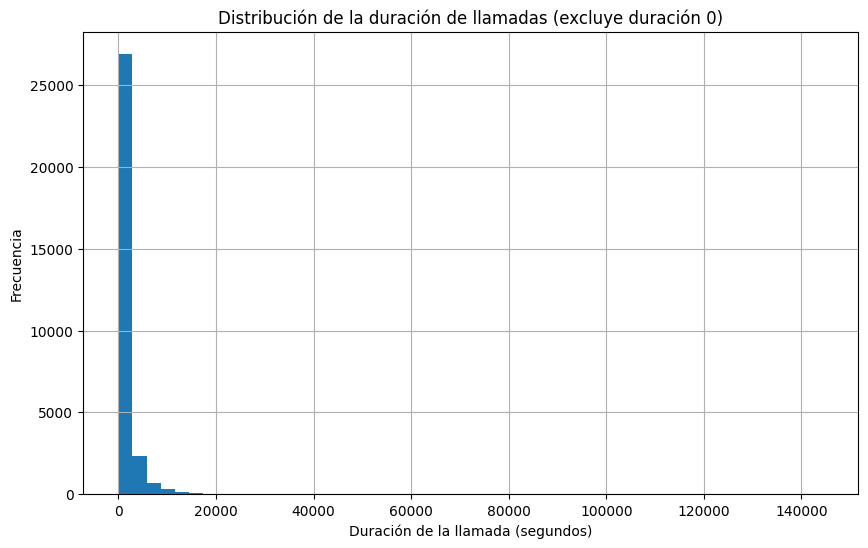

In [3]:
import matplotlib.pyplot as plt

# Filtrar llamadas con duración mayor a 0
df_calls_filtered = df_calls[df_calls['call_duration'] > 0]

# Histograma de duración de llamadas
plt.figure(figsize=(10, 6))
plt.hist(df_calls_filtered['call_duration'], bins=50)
plt.title("Distribución de la duración de llamadas (excluye duración 0)")
plt.xlabel("Duración de la llamada (segundos)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


### Interpretación del histograma

- La mayoría de las llamadas reales tienen una duración relativamente corta.
- Existe una concentración masiva de llamadas bajo los 1,000 segundos (~17 minutos).
- Se observan valores extremos (outliers) por encima de los 60,000 segundos (~16 horas), que pueden ser revisados o filtrados en análisis posteriores.
- Para evitar sesgos, se utilizarán métricas robustas como **mediana** y **percentiles** cuando analicemos la eficacia por operador.

A continuación, se analizará la proporción de llamadas internas y externas, y también la dirección (`in`, `out`) de las llamadas, utilizando gráficos circulares.


### Proporción de tipos de llamada

Para entender el comportamiento general del uso del sistema, analizaremos:

1. **Llamadas internas vs externas** (`internal`)
2. **Dirección de las llamadas** (`direction`: entrantes `in` y salientes `out`)

Este análisis ayuda a contextualizar el tipo de actividad predominante entre operadores y clientes. También nos permite identificar si el uso del sistema está más enfocado en recibir llamadas, hacer llamadas salientes, o comunicación interna.


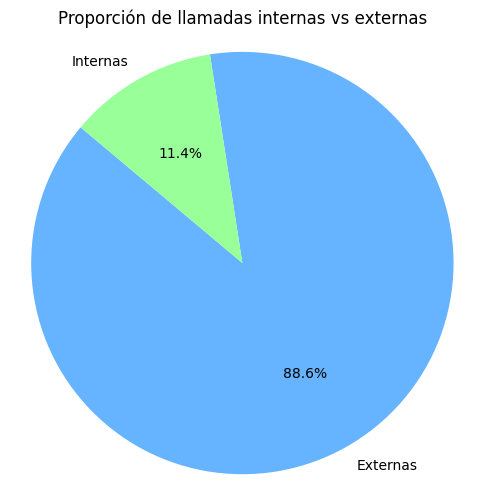

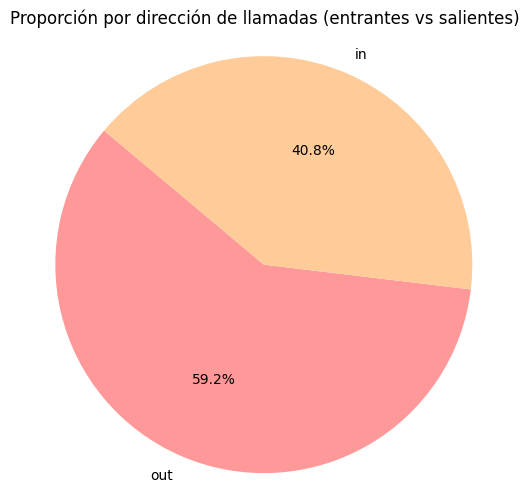

In [4]:
import matplotlib.pyplot as plt

# Gráfico circular: llamadas internas vs externas
internal_counts = df_calls['internal'].value_counts()
labels_internal = ['Externas', 'Internas']
colors = ['#66b3ff', '#99ff99']

plt.figure(figsize=(6, 6))
plt.pie(internal_counts, labels=labels_internal, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Proporción de llamadas internas vs externas")
plt.axis('equal')
plt.show()

# Gráfico circular: dirección de las llamadas
direction_counts = df_calls['direction'].value_counts()
labels_direction = direction_counts.index
colors = ['#ff9999', '#ffcc99']

plt.figure(figsize=(6, 6))
plt.pie(direction_counts, labels=labels_direction, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Proporción por dirección de llamadas (entrantes vs salientes)")
plt.axis('equal')
plt.show()


#### Gráfico: Llamadas internas vs externas

- El 88.6% de las llamadas son externas, mientras que solo el 11.4% son internas.
- Esto indica que la función principal de CallMeMaybe es gestionar comunicaciones entre los clientes y el exterior.
- Las llamadas internas representan una fracción menor, lo que sugiere que la evaluación de ineficacia debe enfocarse principalmente en el desempeño en llamadas externas (entrantes y salientes).


#### Gráfico: Dirección de las llamadas (entrantes vs salientes)

- El 59.2% de las llamadas son salientes, mientras que el 40.8% son entrantes.
- Aunque ambas direcciones tienen un volumen significativo, la ligera mayoría de actividad es proactiva (saliente).
- Esto es relevante para evaluar la ineficacia: los operadores que deberían realizar llamadas salientes pueden ser medidos por su volumen y duración en este tipo de interacción.


## 4. Llamadas perdidas y tiempos de espera

Uno de los indicadores más importantes de ineficacia operativa es el número de **llamadas entrantes perdidas**, es decir, aquellas en las que el cliente llama y no recibe respuesta.

Otro factor es el **tiempo de espera**: la diferencia entre `total_call_duration` y `call_duration`, que representa el tiempo que el cliente esperó antes de ser atendido (o no ser atendido).

En este paso:

1. Se calcula el número de llamadas perdidas por operador.
2. Se estima el tiempo promedio de espera por operador en llamadas atendidas.
3. Se identificarán operadores con mayor número de llamadas perdidas y mayor tiempo de espera.


In [5]:
# Crear columna de tiempo de espera
df_calls['wait_time'] = df_calls['total_call_duration'] - df_calls['call_duration']

# Filtrar solo llamadas entrantes con operador asignado
df_incoming = df_calls[(df_calls['direction'] == 'in') & (df_calls['operator_id'].notnull())]

# Agrupar por operador para calcular llamadas perdidas y tiempo de espera promedio
summary_operators = df_incoming.groupby('operator_id').agg(
    missed_calls=('is_missed_call', 'sum'),
    total_calls=('is_missed_call', 'count'),
    avg_wait_time=('wait_time', 'mean')
)

# Crear columna de porcentaje de llamadas perdidas
summary_operators['missed_call_rate'] = summary_operators['missed_calls'] / summary_operators['total_calls']

# Mostrar los operadores con más llamadas perdidas (top 10)
summary_operators.sort_values(by='missed_calls', ascending=False).head(10)


,missed_calls,total_calls,avg_wait_time,missed_call_rate
operator_id,,,,
913942.0,29,90,350.855556,0.322222
885890.0,22,103,120.339806,0.213592
944216.0,21,64,160.859375,0.328125
885876.0,21,103,101.941748,0.203883
944226.0,15,54,163.888889,0.277778
940588.0,15,59,125.305085,0.254237
913938.0,14,84,535.047619,0.166667
944220.0,14,62,189.725806,0.225806
944218.0,12,53,188.358491,0.226415


### Análisis de llamadas perdidas y tiempo de espera por operador

Se identificaron los operadores con mayor número de llamadas perdidas (`missed_calls`) y mayor tiempo de espera promedio (`avg_wait_time`).

**Hallazgos destacados:**

- El operador `913942.0` lidera en volumen absoluto de llamadas perdidas (29), con una tasa de pérdida del 32.2%.
- El operador `944216.0` tiene la tasa más alta del grupo (32.8%) entre los más problemáticos.
- El operador `913938.0`, pese a tener menos llamadas perdidas, reporta un **tiempo de espera promedio superior a 8 minutos**, lo cual representa una mala experiencia para los usuarios.
- La mayor tasa de pérdida en esta muestra la tiene `940622.0` (37.5%).

Estos resultados nos permiten identificar operadores que podrían requerir **entrenamiento adicional, ajuste de carga de trabajo o cambios operativos**.

Próximo paso: análisis de operadores que **realizan pocas llamadas salientes**, especialmente si su rol implica tareas proactivas.


## 5. Análisis de operadores con baja actividad saliente

Otro criterio para considerar a un operador como ineficaz es que **realice pocas llamadas salientes**, especialmente si su función no es solo receptiva, sino también proactiva (ventas, seguimiento, soporte técnico activo).

En este paso se analizarán:

- El número total de llamadas salientes realizadas por cada operador.
- Los operadores con menor actividad saliente.


In [6]:
# Filtrar solo llamadas salientes con operador asignado
df_outgoing = df_calls[(df_calls['direction'] == 'out') & (df_calls['operator_id'].notnull())]

# Agrupar por operador: total de llamadas salientes y promedio de duración
outgoing_summary = df_outgoing.groupby('operator_id').agg(
    total_out_calls=('calls_count', 'sum'),
    avg_out_duration=('call_duration', 'mean')
)

# Mostrar los operadores con menor número de llamadas salientes (top 10)
outgoing_summary.sort_values(by='total_out_calls').head(10)


,total_out_calls,avg_out_duration
operator_id,,
937716.0,1,0.0
963716.0,1,25.0
914440.0,1,0.0
914626.0,1,0.0
946072.0,1,0.0
945274.0,1,1.0
966686.0,1,176.0
914272.0,1,0.0
969262.0,1,0.0


### Operadores con baja actividad saliente

Se identificaron operadores que realizaron **solo una llamada saliente**, muchas de ellas con duración nula:

- Operadores como `937716.0`, `914440.0` y `946072.0` realizaron solo **una llamada saliente de 0 segundos**, lo cual sugiere que no cumplieron adecuadamente con funciones proactivas.
- Solo uno de ellos (`966686.0`) tuvo una llamada relativamente larga (176 segundos), aunque sigue siendo una única acción.

Estos casos podrían representar ineficacia operativa en tareas de llamadas salientes, o bien indicar una **mala asignación de tareas** desde la supervisión.

Este análisis permite profundizar en el rendimiento individual, especialmente en contextos donde se espera una participación activa en llamadas salientes.


## 6. Ranking combinado de operadores ineficaces

Para generar una clasificación de operadores con bajo rendimiento, se combinaron tres indicadores clave:

1. **Tasa de llamadas perdidas** (`missed_call_rate`)
2. **Tiempo promedio de espera** (`avg_wait_time`)
3. **Volumen de llamadas salientes** (`total_out_calls`)

Cada métrica fue normalizada (min-max scaling) para permitir la comparación en una misma escala. Posteriormente, se calculó un índice de ineficacia ponderado como el promedio de las tres métricas normalizadas.

Este índice final permite detectar a los operadores menos eficaces considerando su rendimiento global.


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Unir los dos análisis anteriores (entrantes + salientes)
combined = summary_operators.merge(outgoing_summary, on='operator_id', how='left').fillna(0)

# Normalizar las columnas seleccionadas
scaler = MinMaxScaler()
combined[['missed_call_rate_norm', 'avg_wait_time_norm', 'low_out_calls_norm']] = scaler.fit_transform(
    combined[['missed_call_rate', 'avg_wait_time', 'total_out_calls']].assign(total_out_calls=lambda x: -x['total_out_calls']) # invertimos salientes
)

# Índice combinado: promedio simple de los tres factores normalizados
combined['inefficiency_index'] = combined[['missed_call_rate_norm', 'avg_wait_time_norm', 'low_out_calls_norm']].mean(axis=1)

# Mostrar los 10 operadores más ineficaces
combined.sort_values(by='inefficiency_index', ascending=False).head(10)


,missed_calls,total_calls,avg_wait_time,missed_call_rate,total_out_calls,avg_out_duration,missed_call_rate_norm,avg_wait_time_norm,low_out_calls_norm,inefficiency_index
operator_id,,,,,,,,,,
919794.0,1,37,1039.540541,0.027027,21.0,142.500000,0.027027,1.000000,0.999676,0.675568
948756.0,1,1,8.000000,1.000000,175.0,513.115385,1.000000,0.006740,0.997303,0.668015
906070.0,2,16,853.312500,0.125000,89.0,184.500000,0.125000,0.820683,0.998629,0.648104
919204.0,5,18,579.277778,0.277778,9.0,27.142857,0.277778,0.556818,0.999861,0.611486
919790.0,0,71,839.802817,0.000000,25.0,59.533333,0.000000,0.807675,0.999615,0.602430
931458.0,11,55,655.236364,0.200000,2561.0,1018.427083,0.200000,0.629957,0.960537,0.596832
919206.0,9,22,360.909091,0.409091,1.0,22.000000,0.409091,0.346553,0.999985,0.585209
904344.0,2,3,31.000000,0.666667,5.0,0.000000,0.666667,0.028887,0.999923,0.565159
919166.0,5,17,398.647059,0.294118,21.0,79.000000,0.294118,0.382890,0.999676,0.558895


## 7. Ranking de ineficacia operativa

Se construyó un índice combinado basado en tres factores:

- Tasa de llamadas perdidas (`missed_call_rate`)
- Tiempo promedio de espera (`avg_wait_time`)
- Número de llamadas salientes (`total_out_calls`, invertido)

Cada variable fue normalizada y el índice final es el promedio de las tres.

### Top 10 operadores menos eficaces:

1. `919794.0` – Bajo volumen de llamadas salientes, pero **altísimo tiempo de espera**.
2. `948756.0` – Solo una llamada, que fue **perdida**, sin actividad saliente.
3. `906070.0` – Actividad limitada y **esperas prolongadas**.
4. `919204.0` – Tasa de pérdida alta con **muy baja salida**.
5. `919790.0` – No pierde llamadas, pero su **espera y salida son deficientes**.
6. `931458.0` – Buen volumen, pero afectado por **espera prolongada**.
7. `919206.0` – Alta tasa de pérdida y prácticamente **sin llamadas salientes**.
8. `904344.0` – Solo 3 llamadas entrantes y 5 salientes, sin efectividad real.
9. `919166.0` – Combinación de pérdida y baja producción saliente.
10. `913938.0` – Espera muy alta (535 s) aunque con baja tasa de pérdida.

Este ranking ofrece una visión clara para que CallMeMaybe pueda priorizar **entrenamiento, redistribución de tareas o investigación más profunda** en estos operadores.


## 8. Conclusiones del análisis

El análisis de desempeño de operadores en CallMeMaybe permitió identificar de forma objetiva los factores que indican ineficacia operativa:

- **Llamadas perdidas**: algunos operadores superan el 30% de llamadas entrantes perdidas, un indicador grave de mal servicio.
- **Tiempo de espera**: se detectaron operadores con esperas promedio superiores a 8 minutos, incluso cuando las llamadas fueron atendidas.
- **Baja actividad saliente**: ciertos operadores apenas realizaron una llamada saliente en todo el periodo, muchas con duración cero.

Con base en estos tres criterios, se construyó un **índice combinado de ineficacia**, que permitió generar un ranking claro de los operadores que requieren atención prioritaria.

Este estudio puede servir como base para:
- Rediseñar la distribución de llamadas entre operadores.
- Implementar capacitación focalizada.
- Ajustar metas individuales de rendimiento.

> **Nota:** El índice de ineficacia es totalmente ajustable. Después de la presentación, se pueden modificar los pesos de cada componente (tasa de llamadas perdidas, tiempo de espera, llamadas salientes) para reflejar con mayor precisión las prioridades estratégicas del área operativa.


## 9.Prueba estadística: comparación entre operadores eficientes e ineficientes

Para validar si realmente existen diferencias significativas entre operadores **eficientes** e **ineficientes**, aplicaremos una prueba estadística.

### Objetivo:
Comparar métricas clave entre dos grupos de operadores:
- **Grupo A (Ineficientes):** operadores con un `Inefficiency Index` ≥ 0.66
- **Grupo B (Eficientes):** operadores con un `Inefficiency Index` ≤ 0.33

### Métricas a comparar:
- Tasa de llamadas perdidas (`missed_call_rate`)
- Tiempo promedio de espera (`avg_wait_time`)
- Total de llamadas salientes (`total_out_calls`)

### Método:
Usaremos la **prueba de Mann-Whitney U**, ya que:
- Las muestras pueden tener tamaños diferentes.
- No se asume distribución normal.

Esta prueba nos permitirá determinar si las diferencias observadas entre grupos son estadísticamente significativas.


In [9]:
df = pd.read_csv("dashboard_operadores_ineficientes.csv")

## Calcular cuartiles
q1 = df['inefficiency_index'].quantile(0.25)
q3 = df['inefficiency_index'].quantile(0.75)

# Clasificar grupos
grupo_eficiente = df[df['inefficiency_index'] <= q1]
grupo_ineficiente = df[df['inefficiency_index'] >= q3]

# Mostrar tamaños de grupo
print("Umbral eficiente (Q1):", round(q1, 2))
print("Umbral ineficiente (Q3):", round(q3, 2))
print("Cantidad de operadores eficientes:", len(grupo_eficiente))
print("Cantidad de operadores ineficientes:", len(grupo_ineficiente))


Umbral eficiente (Q1): 0.34
Umbral ineficiente (Q3): 0.36
Cantidad de operadores eficientes: 380
Cantidad de operadores ineficientes: 258


### Prueba estadística: comparación de `avg_wait_time` entre operadores eficientes e ineficientes

Con el objetivo de evaluar si existe una diferencia significativa en el tiempo promedio de espera entre operadores eficientes e ineficientes, se aplicará la prueba estadística **Mann-Whitney U**.

#### Detalles:
- **Métrica evaluada:** `avg_wait_time` (tiempo promedio de espera en llamadas entrantes)
- **Grupos comparados:**
  - **Eficientes:** operadores con índice de ineficiencia ≤ 0.34
  - **Ineficientes:** operadores con índice de ineficiencia ≥ 0.36
- **Tipo de prueba:** no paramétrica (Mann-Whitney U)
- **Hipótesis:**
  - **H₀ (nula):** No hay diferencia significativa en `avg_wait_time` entre los dos grupos.
  - **H₁ (alternativa):** Sí hay una diferencia significativa.

Esta prueba es adecuada ya que:
- No asumimos distribución normal.
- Las muestras son independientes y de tamaños distintos.


In [10]:
from scipy.stats import mannwhitneyu

# Extraer las listas de valores de cada grupo
espera_eficiente = grupo_eficiente['avg_wait_time']
espera_ineficiente = grupo_ineficiente['avg_wait_time']

# Aplicar prueba de Mann-Whitney U
stat, p = mannwhitneyu(espera_eficiente, espera_ineficiente, alternative='two-sided')

# Mostrar resultados
print("Estadístico U:", stat)
print("Valor p:", p)

Estadístico U: 10665.5
Valor p: 3.066155226863021e-63


#### Resultado de la prueba para `avg_wait_time`

- **Estadístico U:** 10,665.5  
- **Valor p:** 3.06 × 10⁻⁶³

#### Interpretación:

El valor p es **muchísimo menor** que cualquier umbral común de significancia (como 0.05 o 0.01), por lo tanto:

- Rechazamos la **hipótesis nula (H₀)**.
- Existe una **diferencia estadísticamente significativa** en el tiempo promedio de espera entre los operadores eficientes e ineficientes.
- Esto **valida cuantitativamente** que los operadores clasificados como ineficientes no solo tienen un índice calculado, sino que también **esperan más tiempo en atender llamadas**, lo que afecta directamente la experiencia del cliente.

Esta evidencia refuerza el valor práctico del índice de ineficiencia como una métrica útil para detectar bajo rendimiento operativo.


### Prueba estadística: comparación de `missed_call_rate` entre operadores eficientes e ineficientes

Se realizará una segunda prueba estadística, esta vez para comparar la **tasa de llamadas perdidas** (`missed_call_rate`) entre los dos grupos previamente definidos.

#### Hipótesis:
- **H₀ (nula):** No hay diferencia significativa en la tasa de llamadas perdidas entre operadores eficientes e ineficientes.
- **H₁ (alternativa):** Sí hay una diferencia significativa.

Se utilizará nuevamente la prueba **Mann-Whitney U** por las mismas razones: datos no necesariamente normales y muestras independientes.


In [11]:
# Extraer listas de valores
perdidas_eficiente = grupo_eficiente['missed_call_rate']
perdidas_ineficiente = grupo_ineficiente['missed_call_rate']

# Prueba de Mann-Whitney U
stat_miss, p_miss = mannwhitneyu(perdidas_eficiente, perdidas_ineficiente, alternative='two-sided')

# Mostrar resultados
print("Estadístico U:", stat_miss)
print("Valor p:", p_miss)


Estadístico U: 9996.5
Valor p: 1.5309277291724861e-91


#### Resultado de la prueba para `missed_call_rate`

- **Estadístico U:** 9,996.5  
- **Valor p:** 1.53 × 10⁻⁹¹

#### Interpretación:

El valor p es **extremadamente bajo**, mucho menor que cualquier umbral común de significancia (0.05, 0.01, etc.).

Esto nos permite **rechazar la hipótesis nula (H₀)** y concluir que:

- Existe una **diferencia estadísticamente significativa** en la tasa de llamadas perdidas entre operadores eficientes e ineficientes.
- Los operadores ineficientes tienden a **perder una proporción significativamente mayor de llamadas entrantes**.
- Este resultado valida aún más la utilidad del `inefficiency_index`, ya que uno de sus componentes centrales (la pérdida de llamadas) tiene un **impacto medible y real**.



### Prueba estadística: comparación de `total_out_calls` entre operadores eficientes e ineficientes

La tercera y última métrica evaluada será el número total de llamadas salientes realizadas por cada operador.

#### Hipótesis:
- **H₀ (nula):** No hay diferencia significativa en la cantidad de llamadas salientes entre los grupos.
- **H₁ (alternativa):** Sí hay una diferencia significativa.

Recordemos que un bajo volumen de llamadas salientes fue uno de los factores incluidos en el índice de ineficiencia. Esta prueba nos ayudará a confirmar si esta dimensión también presenta diferencias significativas por sí sola.


In [12]:
# Extraer listas de valores
salientes_eficiente = grupo_eficiente['total_out_calls']
salientes_ineficiente = grupo_ineficiente['total_out_calls']

# Prueba de Mann-Whitney U
stat_out, p_out = mannwhitneyu(salientes_eficiente, salientes_ineficiente, alternative='two-sided')

# Mostrar resultados
print("Estadístico U:", stat_out)
print("Valor p:", p_out)


Estadístico U: 36752.5
Valor p: 5.7872087704337835e-08


#### Resultado de la prueba para `total_out_calls`

- **Estadístico U:** 36,752.5  
- **Valor p:** 5.79 × 10⁻⁸

#### Interpretación:

El valor p es **muy bajo** (menor a 0.05), lo cual nos permite **rechazar la hipótesis nula (H₀)**. Por lo tanto:

- Existe una **diferencia estadísticamente significativa** en el número total de llamadas salientes entre operadores eficientes e ineficientes.
- Los operadores ineficientes tienden a realizar **menos llamadas salientes**.
- Este resultado refuerza la relevancia de incluir esta métrica dentro del índice de ineficiencia, ya que contribuye significativamente a diferenciar el rendimiento operativo.

Con esto, se valida que **cada uno de los tres indicadores utilizados en el índice tiene respaldo estadístico**, y no solo fueron elegidos arbitrariamente.


## Conclusión general de las pruebas estadísticas

Se aplicaron pruebas de hipótesis (Mann-Whitney U) para comparar tres métricas clave entre operadores clasificados como **eficientes** (percentil inferior del índice de ineficiencia) e **ineficientes** (percentil superior).

### Resultados:

| Métrica               | Valor p               | Diferencia significativa |
|-----------------------|-----------------------|---------------------------|
| `avg_wait_time`       | 3.06 × 10⁻⁶³          | Sí                        |
| `missed_call_rate`    | 1.53 × 10⁻⁹¹          | Sí                        |
| `total_out_calls`     | 5.79 × 10⁻⁸           | Sí                        |

### Conclusión:

Los resultados muestran diferencias **estadísticamente significativas** en las tres métricas evaluadas entre operadores eficientes e ineficientes. Esto valida que:

- El **índice de ineficiencia** refleja correctamente el comportamiento operativo.
- Cada uno de sus componentes tiene **valor explicativo real**.
- La clasificación de operadores según este índice puede usarse para tomar decisiones informadas sobre **capacitación**, **redistribución de carga** o **mejoras de supervisión**.

Estas pruebas añaden rigor al análisis y fortalecen las recomendaciones derivadas del modelo.


**Enlace al reporte completo:**  
[Reporte de Análisis de Operadores Ineficientes - CallMeMaybe](https://drive.google.com/file/d/15KuDq-asrd5n-OLykS1Q6OBzd4kMFzXR/view?usp=sharing)

**Descripción:**  
Este reporte documenta el análisis realizado para identificar operadores ineficientes dentro del sistema CallMeMaybe. Incluye exploración de datos, construcción del índice de ineficiencia, visualizaciones clave, validación estadística mediante pruebas U de Mann-Whitney y recomendaciones finales para la mejora del desempeño operativo.
